In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os

In [144]:

if not os.path.isfile('RGT_001.h5'):
    from pykml import parser
    import h5py

    thefile='IS2_RGT_0001_cycle16_21-Jun-2022.kml'
    with open(thefile,'r') as fh:
        doc=parser.parse(fh).getroot().Document
        ll=np.c_[[[*map(float,item.split(','))] for item in str(doc.Placemark.LineString.coordinates).split(' ')[:-1]]]
        temp=pc.data().from_dict({'latitude':ll[:,1],'longitude':ll[:,0]})
    temp.assign(t=np.linspace(0, 90.75/1387, len(temp.latitude)))
    
    RGT1=temp
    dLat_dt=np.diff(RGT1.latitude[0:2])/np.diff(RGT1.t[0:2])
    t0 = RGT1.latitude[0]/dLat_dt
    RGT1.t += t0
    dLon_dt = np.diff(RGT1.longitude[0:2])/np.diff(RGT1.t[0:2])
    lon0 = RGT1.longitude[0] - dLon_dt*RGT1.t[0]

    dLat_dt=np.diff(RGT1.latitude[-2:])/np.diff(RGT1.t[-2:])
    tN = RGT1.t[-1]-RGT1.latitude[-1]/dLat_dt
    dLon_dt = np.diff(RGT1.longitude[-2:])/np.diff(RGT1.t[-2:])
    lonN = RGT1.longitude[-1]+dLon_dt*(tN-RGT1.t[-1])
    RGT1.to_h5('RGT_001.h5', replace=True)
    with h5py.File('RGT_001.h5','r+') as h5f:
        h5f.attrs['t_orbit'] = tN-t0
        h5f.attrs['delta_lon_orbit'] = lonN-lon0
else:
    RGT1 = pc.data().from_h5('RGT_001.h5')
    with h5py.File('RGT_001.h5','r') as h5f:
        t_orbit = h5f.attrs['t_orbit']
        delta_lon_orbit=h5f.attrs['delta_lon_orbit']


In [191]:
RGT1=None
RGT1 = pc.data().from_h5('RGT_001.h5', group='/')
with h5py.File('RGT_001.h5','r') as h5f:
    t_orbit = h5f.attrs['t_orbit']
    # correction value
    delta_lon_orbit=h5f.attrs['delta_lon_orbit'] + 0.00754

lat_0 = 70
lon_0 = 0
W = 2.e4
lat_tol = np.maximum(W, 7000)/(6378e3*2*np.pi/360.)
lon_tol = np.maximum(W+3000, 10000)/(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))

desc = (RGT1.t > t_orbit/4) & (RGT1.t < 3*t_orbit/4)
asc = desc==0

RGT_desc = RGT1[desc & (np.abs(RGT1.latitude - lat_0) < lat_tol)]
RGT_asc = RGT1[asc & (np.abs(RGT1.latitude - lat_0) < lat_tol)]

orbs={key:[] for key in ['asc','desc']}

for track in range(1387):
    for key, RGT in zip(['asc','desc'], [RGT_asc, RGT_desc]):
        temp=RGT.copy()
        temp.t += t_orbit*track
        temp.longitude += delta_lon_orbit * track
        delta_lon = np.mod(temp.longitude-lon_0+180, 360)-180
        if np.any(np.abs(delta_lon) < lon_tol):
            temp.longitude = np.mod(temp.longitude+180, 360)-180
            orbs[key] += [temp]


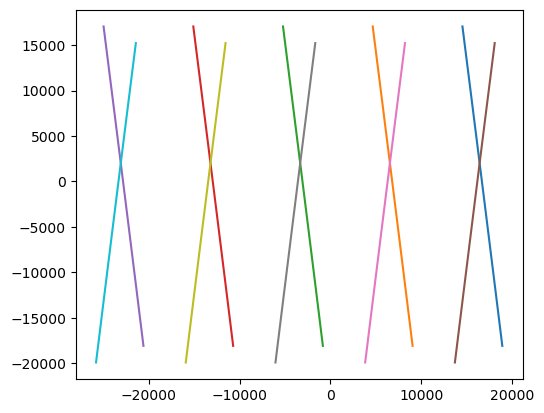

In [194]:
plt.figure();
lat_scale=(6378e3*2*np.pi/360.)
lon_scale=(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))

for key, orb_list in orbs.items():
    for orb in orb_list:
        plt.plot((orb.longitude-lon_0)*lon_scale, (orb.latitude-lat_0)*lat_scale)
plt.gca().set_aspect(1)

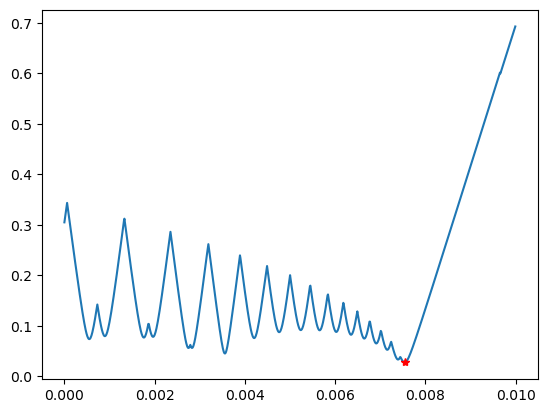

In [189]:
#plt.figure(); plt.plot(np.unique(np.mod((0.0008+delta_lon_orbit)*np.arange(1387)+180, 360)-180)[0:30], '.')

#plt.figure(); plt.hist(np.diff(np.unique(np.mod((0+delta_lon_orbit)*np.arange(1387)+180, 360)-180)))

delta_vals=np.arange(0, 0.01, 0.00001)
sigma_dlon = np.array([np.std(np.diff(np.unique(np.mod((delta_i+delta_lon_orbit)*np.arange(1387)+180, 360)-180))) for delta_i in delta_vals])
plt.figure()
plt.plot(delta_vals, sigma_dlon)
delta=delta_vals[np.argmin(sigma_dlon)]
plt.plot(delta, sigma_dlon[np.argmin(sigma_dlon)],'r*')

In [190]:
delta

0.007540000000000001

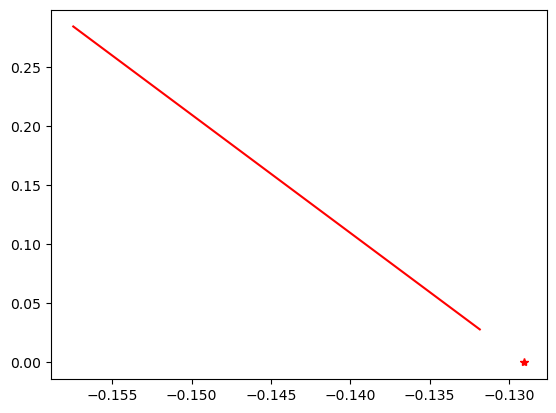

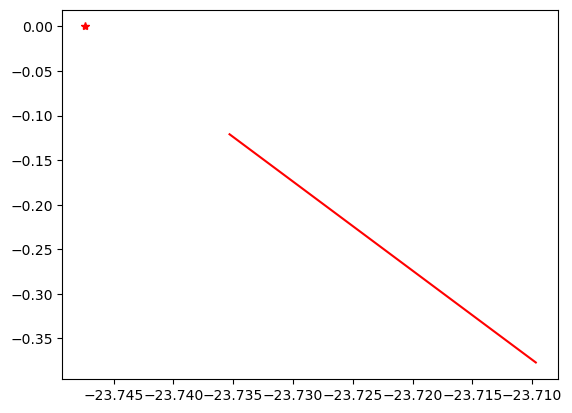

In [131]:
plt.figure()
plt.plot(lon0, 0,'r*')
plt.plot(RGT1.longitude[0:5], RGT1.latitude[0:5],'r')
plt.figure()
plt.plot(lonN, 0, 'r*')
plt.plot(RGT1.longitude[-5:], RGT1.latitude[-5:],'r')

2


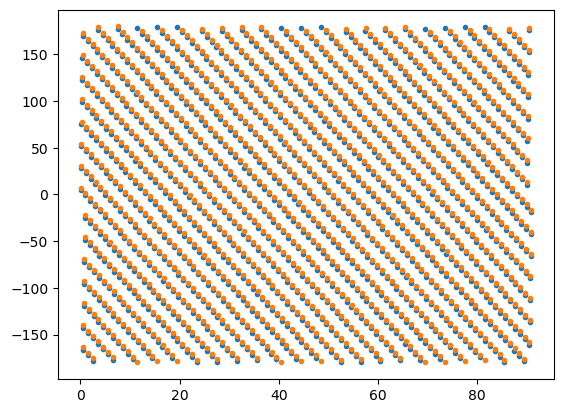

In [68]:

W=10000
lon_0=0
t_gt = np.linspace(0., 91., 1388)[0:-1]
dt_orb = t_gt[1]-t_gt[0]
lon_gt = np.mod(t_gt*360+180, 360)-180

lat_0=70
dt_asc = lat_0/360  *dt_orb  # time for the orbit to reach the simulation center
dt_desc = (90 + (90-lat_0))/360 * dt_orb

t_asc = t_gt + dt_asc
lon_asc=np.mod(t_asc*360+180, 360)-180
t_desc = t_gt + dt_desc
lon_desc=np.mod(t_desc*360+180, 360)-180

W_lon = W*360/(2*np.pi*6378e3*np.cos(lat_0*np.pi/180))

asc_orbs = np.abs(lon_0-lon_asc) < W_lon
print(np.sum(asc_orbs))

plt.figure(); plt.plot(t_asc, lon_asc,'.')
plt.plot(t_desc, lon_desc,'.')

In [33]:
l_AT = 8
AT_spacing=0.25
azimuth=30
beam_spacing=3
N_GT=1
GT_spacing

s=np.arange(-8, 8, 0.25)
xy0=np.concatenate([np.c_[s, s*0+delta].T for delta in [-beam_spacing, 0, beam_spacing]], axis=1)
theta=60*np.pi/180
xy = []
t=[]
for count, theta in enumerate([(90-azimuth)*np.pi/180, (90+azimuth)*np.pi/180]):
    R=[[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    xy += [R@xy0]
    t += [np.zeros(xy0.shape[1])+count/2]
xy_cycle=np.concatenate(xy, axis=1)
t_cycle=np.concatenate(t)

In [37]:
xy=[]
t=[]
for cycle in range(10):
    xy += [xy_cycle]
    t += [t_cycle+cycle]
xy=np.concatenate(xy, axis=1)
t=np.concatenate(t)

In [41]:
D=pc.data().from_dict({'x':xy[0,:], 'y':xy[1,:],'t':t})
D.ravel_fields()

<class 'pointCollection.data.data'> with shape (3840,),
with fields:
['x', 'y', 't']

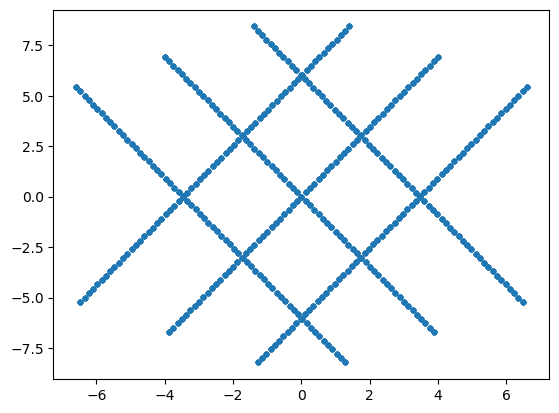

In [42]:
plt.plot(D.x, D.y,'.')

In [53]:
D.assign(z=1-0.01*(D.x**2+D.y**2) - 0.01*D.t + (np.abs(D.t)>2)*(D.t-2)*np.exp(-(D.x**2+D.y**2)/(2*0.5)))

<class 'pointCollection.data.data'> with shape (3840,),
with fields:
['x', 'y', 't', 'z']

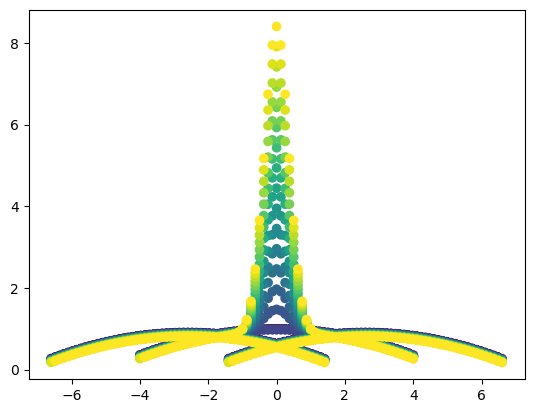

In [54]:
plt.figure()
plt.scatter(D.x, D.z, c=D.t)